Belle adalah sistem rekomendasi berbasis Large Language Model (LLM) yang diimplementasikan pada Conversational Recommender System (CRS) untuk produk kecantikan. Sistem ini menggunakan GPT-4o sebagai model LLM dasarnya. Dataset yang digunakan berasal dari Kaggle dengan judul 'Sephora Products and Skincare Reviews' (url: https://www.kaggle.com/datasets/nadyinky/sephora-products-and-skincare-reviews/).

Pengembangan sistem meliputi beberapa tahap:
1. Preprocessing data
2. Fine-tuning model
3. Menggunakan OpenAI API
4. Prompt engineering
5. Evaluasi kinerja

Evaluasi dilakukan menggunakan dua metrik utama:
1. Evaluasi semantik melalui BERTScore dan cosine similarity
2. Evaluasi keberagaman respon menggunakan Distinct-n.

URL Bot Telegram Belle: https://t.me/Belle_beautybyel_bot

### Import Library

In [ ]:
import pandas as pd
import openai
from openai import OpenAI
from sklearn.metrics.pairwise import cosine_similarity
import logging
from typing import List, Dict
import ast
import nest_asyncio
import json

!pip install python-telegram-bot
from telegram._update import Update
from telegram.ext import Application, CommandHandler, MessageHandler, filters, ContextTypes


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 662.7/662.7 kB 6.8 MB/s eta 0:00:00


In [ ]:
# Load dataset
url = 'https://drive.google.com/uc?id=' + '1yVvjvMCBwJ4PUiqkxuzkT-Xqqxdp6wbG'

# Membaca dataset
df = pd.read_csv(url)
df.head()

,product_id,product_name,brand_id,brand_name,loves_count,rating,reviews,size,variation_type,variation_value,...,online_only,out_of_stock,sephora_exclusive,highlights,primary_category,secondary_category,tertiary_category,child_count,child_max_price,child_min_price
0,P473671,Fragrance Discovery Set,6342,19-69,6320,3.6364,11.0,NaN,NaN,NaN,...,1,0,0,"['Unisex/ Genderless Scent', 'Warm &Spicy Scen...",Fragrance,Value & Gift Sets,Perfume Gift Sets,0,NaN,NaN
1,P473668,La Habana Eau de Parfum,6342,19-69,3827,4.1538,13.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,85.0,30.0
2,P473662,Rainbow Bar Eau de Parfum,6342,19-69,3253,4.2500,16.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,75.0,30.0
3,P473660,Kasbah Eau de Parfum,6342,19-69,3018,4.4762,21.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,75.0,30.0
4,P473658,Purple Haze Eau de Parfum,6342,19-69,2691,3.2308,13.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,75.0,30.0


In [ ]:
# Menampilkan struktur dataset sebelum data dipreprocessing
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8494 entries, 0 to 8493
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   product_id          8494 non-null   object 
 1   product_name        8494 non-null   object 
 2   brand_id            8494 non-null   int64  
 3   brand_name          8494 non-null   object 
 4   loves_count         8494 non-null   int64  
 5   rating              8216 non-null   float64
 6   reviews             8216 non-null   float64
 7   size                6863 non-null   object 
 8   variation_type      7050 non-null   object 
 9   variation_value     6896 non-null   object 
 10  variation_desc      1250 non-null   object 
 11  ingredients         7549 non-null   object 
 12  price_usd           8494 non-null   float64
 13  value_price_usd     451 non-null    float64
 14  sale_price_usd      270 non-null    float64
 15  limited_edition     8494 non-null   int64  
 16  new   

## **Preprocessing**

Berikut adalah langkah-langkah preprocessing yang dilakukan:

1. Menghapus kolom yang tidak relevan.
2. Menghapus baris dengan nilai null pada kolom highlights dan rating.
3. Mengonversi harga dari USD ke IDR dan menghapus kolom price_usd.
4. Mengisi nilai kosong pada kolom tipe objek dengan string kosong dan kolom numerik dengan 0.
5. Memeriksa keberadaan nilai null setelah preprocessing.
6. Menyimpan dataset yang telah diproses ke dalam format JSON untuk digunakan lebih lanjut.






In [ ]:
# Menghapus beberapa kolom yang tidak diperlukan
columns_to_drop = ['product_id', 'brand_id', 'reviews', 'size', 'variation_type', 'variation_value',
                    'variation_desc', 'ingredients', 'value_price_usd', 'sale_price_usd', 'limited_edition',
                    'new', 'online_only', 'out_of_stock', 'sephora_exclusive', 'child_count', 'child_max_price',
                    'child_min_price']

beauty_product = df.drop(columns=columns_to_drop)
beauty_product = beauty_product.dropna(subset=['highlights', 'rating'])

# Memeriksa struktur dataset setelah beberapa kolom dihapus
beauty_product.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6054 entries, 0 to 8490
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   product_name        6054 non-null   object 
 1   brand_name          6054 non-null   object 
 2   loves_count         6054 non-null   int64  
 3   rating              6054 non-null   float64
 4   price_usd           6054 non-null   float64
 5   highlights          6054 non-null   object 
 6   primary_category    6054 non-null   object 
 7   secondary_category  6052 non-null   object 
 8   tertiary_category   5321 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 473.0+ KB


In [ ]:
# Konversi harga produk menjadi IDR dengan nilai tukar ~15000
beauty_product['price_idr'] = beauty_product['price_usd'] * 15000
beauty_product = beauty_product.drop(columns='price_usd')

# Mengisi string kosong untuk kolom objek (seperti kolom highlight, dll.)
for column in beauty_product.select_dtypes(include=['object']).columns:
  beauty_product[column] = beauty_product[column].fillna('')

# Mengisi 0 untuk kolom numerik yang memiliki missing value
for column in beauty_product.select_dtypes(include=['number']).columns:
  beauty_product[column] = beauty_product[column].fillna(0)

# Memeriksa apakah masih ada dengan data null atau kosong
print(beauty_product.isnull().sum())

product_name          0
brand_name            0
loves_count           0
rating                0
highlights            0
primary_category      0
secondary_category    0
tertiary_category     0
price_idr             0
dtype: int64


In [ ]:
# Menampilkan 200 baris pertama dari DataFrame
beauty_product.head(200)

,product_name,brand_name,loves_count,rating,highlights,primary_category,secondary_category,tertiary_category,price_idr
0,Fragrance Discovery Set,19-69,6320,3.6364,"['Unisex/ Genderless Scent', 'Warm &Spicy Scen...",Fragrance,Value & Gift Sets,Perfume Gift Sets,525000.0
1,La Habana Eau de Parfum,19-69,3827,4.1538,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2925000.0
2,Rainbow Bar Eau de Parfum,19-69,3253,4.2500,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2925000.0
3,Kasbah Eau de Parfum,19-69,3018,4.4762,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2925000.0
4,Purple Haze Eau de Parfum,19-69,2691,3.2308,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2925000.0
...,...,...,...,...,...,...,...,...,...
271,DIPBROW Gel - Mini,Anastasia Beverly Hills,65374,3.3403,"['Matte Finish', 'Long-wearing', 'Full Coverag...",Makeup,Eye,Eyebrow,135000.0
272,Luminous Foundation,Anastasia Beverly Hills,64069,4.1304,"['Vegan', 'Good for: Dullness/Uneven Texture',...",Makeup,Face,Foundation,570000.0
275,Norvina Pro Pigment Palette Vol. 3 for Face & ...,Anastasia Beverly Hills,51295,4.6010,"['Matte Finish', 'Shimmer Finish', 'Without Pa...",Makeup,Makeup Palettes,,900000.0
276,Superfine Micro-Stroking Detail Brow Pen,Anastasia Beverly Hills,51057,3.9654,"['Waterproof', 'Natural Finish', 'Liquid Formu...",Makeup,Eye,Eyebrow,330000.0


In [ ]:
# Menyimpan dataset hasil preprocessing dalam format JSON

json_file_path = "beauty_products.json"
beauty_product.to_json(json_file_path, orient='records', indent=4)

print(f"Table data has been saved to {json_file_path}")

Table data has been saved to beauty_products.json


## **Fine-tuning**

Untuk proses fine-tuning, disiapkan sebanyak 210 data dialog dengan format .jsonl yang dibagi menjadi 170 data training dan 40 data validation. Data training digunakan untuk melatih model agar dapat memahami kebutuhan spesifik, yaitu memberikan rekomendasi produk kecantikan. Sementara untuk data validation digunakan untuk mengevaluasi kemampuan model dalam menangani data baru.

Contoh format data adalah sebagai berikut:

    {"messages": [{"role": "system", "content": "Belle is beauty product recommender system."}, {"role": "user", "content": "Can you give me a moisturizers product recommendation for hydrating with a budget around under 500k IDR?"}, {"role": "assistant", "content": "I recommend the Mini Water Bank Blue Hyaluronic Cream Moisturizer by LANEIGE. This moisturizers stands out because:\n1. Rating: 3.5135/5 from 13024 reviews\n2. Key Highlights: Hypoallergenic, Hydrating\n3. Price: 345,000.0 IDR"}]}


Selanjutnya, data training dan validation diunggah ke OpenAI untuk melanjutkan proses fine-tuning.
![Fine-tuning](https://github.com/elvirawlndr/Belle-eval/blob/main/Screenshot%202024-12-30%20100020.png?raw=true)

Proses fine-tuning menghasilkan nilai:



**Training loss      (0.5344)**

**Validation loss    (0.3643)**


In [ ]:
# Inisialisasi kredensial untuk token Telegram, OpenAI, Model GPT-4o, dan
# Model GPT-4o setelah di-fine-tune
TELEGRAM_TOKEN = "
openai.api_key = "
# diambil dari OpenAI
FINE_TUNED_MODEL_NAME = "ft:gpt-4o-2024-08-06:project-ta:beauty-product:AWJoVA78"
PRE_FINE_TUNE_MODEL_NAME = "gpt-4o-2024-08-06"
client = OpenAI(api_key=openai.api_key)

## **Application**

Proses kode dibawah adalah membuat kelas chatbot `BelleRecommenderBot` untuk memberikan rekomendasi produk kecantikan berdasarkan data nyata, masukan pengguna, dan model GPT yang di-fine-tune. Bot ini memuat data produk, memproses input, menyusun rekomendasi, serta menyimpan riwayat percakapan untuk personalisasi, dengan kemampuan menangani error untuk pengalaman pengguna yang lancar.

In [ ]:
# Mengaktifkan nest_asyncio untuk menjalankan async code
nest_asyncio.apply()

In [ ]:
# Menginisialisasi konteks percakapan user
user_contexts = {}

In [ ]:
# Membuat class untuk sistem rekomendasi Belle
class BelleRecommenderBot:
    def __init__(self):
        self.products = self.load_products()

        # System prompt yang mendefinisikan persona dan panduan rekomendasi Belle (prompt engineering)
        self.system_prompt = """You are Belle, a friendly and knowledgeable beauty advisor! Your personality traits are:
          1. Enthusiastic and passionate about beauty products
          2. Empathetic to users' beauty concerns
          3. Well-versed in luxury and drugstore brands
          4. Professional but warm and approachable
          5. Always explains the "why" behind recommendations

          When recommending products:
          - Consider the user's specific needs and preferences
          - Highlight product benefits and unique features
          - Share relevant tips for product usage
          - Consider the price point and value for money
          - Reference the love count and ratings to build trust
          - Organize recommendations by category when giving multiple options
          - Always explains the "why" behind recommendations

          Remember to maintain a conversational tone while providing expert advice!"""

    # Memuat data produk dari file JSON
    def load_products(self) -> List[Dict]:
        try:
            with open('beauty_products.json', 'r', encoding='utf-8') as f:
                products = json.load(f)
            logging.info(f"Successfully loaded {len(products)} products")
            return products
        except FileNotFoundError:
            logging.error("Products database file not found")
            return []
        except json.JSONDecodeError:
            logging.error("Error decoding JSON file")
            return []

    # Mengformat harga ke format IDR dengan pemisah ribuan
    def format_price(self, price_idr: float) -> str:
        """Format price in IDR with thousand separator"""
        return f"IDR {price_idr:,.0f}"

    # Mengkonversi string highlights produk menjadi list
    def parse_highlights(self, highlights_str: str) -> List[str]:
        """Parse highlights string into list"""
        try:
            return ast.literal_eval(highlights_str)
        except:
            return []

    # Fungsi utama untuk mendapatkan rekomendasi berdasarkan input pengguna
    async def get_recommendation(self, user_input: str, user_id: int) -> str:
        # Mengambil konteks percakapan sebelumnya untuk user tertentu (jika ada)
        context = user_contexts.get(user_id, [])

        # Menyiapkan pesan untuk API OpenAI dengan system prompt
        messages = [
            {"role": "system", "content": self.system_prompt}
        ]

        # Menambahkan konteks tentang struktur data produk
        product_context = f"""
          You have access to a beauty product database with the following structure:
          - Product name and brand name
          - Category hierarchy (Primary > Secondary > Tertiary)
          - Price in IDR
          - Ratings and love counts from real users
          - Product highlights and features

          Base your recommendations on these real products and their actual data.
          """
        messages.append({"role": "system", "content": product_context})

        # Menambahkan riwayat percakapan ke dalam messages
        for msg in context:
            messages.append(msg)

        # Menambahkan input dari pengguna
        messages.append({"role": "user", "content": user_input})

        # Mendapatkan rekomendasi dari model fine-tuned GPT
        try:
            response = client.chat.completions.create(
                model=FINE_TUNED_MODEL_NAME,
                messages=messages,
                max_tokens=400,
                temperature=0.7
            )

            recommendation = response.choices[0].message.content

            # Menyimpan percakapan ke dalam history
            context.extend([
                {"role": "user", "content": user_input},
                {"role": "assistant", "content": recommendation}
            ])

            # Membatasi panjang history percakapan
            if len(context) > 10:
                context = context[-10:]

            # Memperbarui konteks percakapan/preferensi pengguna
            user_contexts[user_id] = context

            return recommendation

        except Exception as e:
            logging.error(f"Error getting recommendation: {str(e)}")
            return "I'm having a moment! 😅 Could you please try asking me again? I want to make sure I give you the perfect recommendation!"

In [ ]:
# PRE FINE TUNED MODEL                                                            (HANYA UNTUK MENGAMBIL DATA YANG DIGUNAKAN DALAM PENGUJIAN)
# class BelleRecommenderBot:
#     def __init__(self):
#         self.products = self.load_products()
#         self.system_prompt = """You are Belle, a friendly and knowledgeable beauty advisor! Your personality traits are:
#           1. Enthusiastic and passionate about beauty products
#           2. Empathetic to users' beauty concerns
#           3. Well-versed in luxury and drugstore brands
#           4. Professional but warm and approachable
#           5. Always explains the "why" behind recommendations

#           When recommending products:
#           - Consider the user's specific needs and preferences
#           - Highlight product benefits and unique features
#           - Share relevant tips for product usage
#           - Consider the price point and value for money
#           - Reference the love count and ratings to build trust
#           - Organize recommendations by category when giving multiple options
#           - Always explains the "why" behind recommendations

#           Remember to maintain a conversational tone while providing expert advice!"""

#     def load_products(self) -> List[Dict]:
#         try:
#             with open('beauty_products.json', 'r', encoding='utf-8') as f:
#                 products = json.load(f)
#             logging.info(f"Successfully loaded {len(products)} products")
#             return products
#         except FileNotFoundError:
#             logging.error("Products database file not found")
#             return []
#         except json.JSONDecodeError:
#             logging.error("Error decoding JSON file")
#             return []

#     def format_price(self, price_idr: float) -> str:
#         """Format price in IDR with thousand separator"""
#         return f"IDR {price_idr:,.0f}"

#     def parse_highlights(self, highlights_str: str) -> List[str]:
#         """Parse highlights string into list"""
#         try:
#             return ast.literal_eval(highlights_str)
#         except:
#             return []

#     async def get_recommendation(self, user_input: str, user_id: int) -> str:
#         context = user_contexts.get(user_id, [])

#         # Prepare conversation context
#         messages = [
#             {"role": "system", "content": self.system_prompt}
#         ]

#         # Add relevant product context
#         product_context = f"""
#           You have access to a beauty product database with the following structure:
#           - Product name and brand name
#           - Category hierarchy (Primary > Secondary > Tertiary)
#           - Price in IDR
#           - Ratings and love counts from real users
#           - Product highlights and features

#           Base your recommendations on these real products and their actual data.
#           """
#         messages.append({"role": "system", "content": product_context})

#         # Add conversation history
#         for msg in context:
#             messages.append(msg)

#         # Add current user input
#         messages.append({"role": "user", "content": user_input})

#         try:
#             response = await client.chat.completions.create(
#                 model=PRE_FINE_TUNE_MODEL_NAME,
#                 messages=messages,
#                 max_tokens=400,
#                 temperature=0.7
#             )

#             recommendation = response.choices[0].message.content

#             # Update conversation history
#             context.extend([
#                 {"role": "user", "content": user_input},
#                 {"role": "assistant", "content": recommendation}
#             ])

#             # Manage context length
#             if len(context) > 10:
#                 context = context[-10:]

#             user_contexts[user_id] = context

#             return recommendation

#         except Exception as e:
#             logging.error(f"Error getting recommendation: {str(e)}")
#             return "I'm having a moment! 😅 Could you please try asking me again? I want to make sure I give you the perfect recommendation!"

Selanjutnya ditaambahkan fitur interaksi chatbot dengan pengguna melalui Telegram. Fitur ini mencakup menyambut pengguna dengan pesan selamat datang saat menggunakan perintah `/start`, memberikan panduan melalui perintah `/help`, merespons masukan pengguna dengan rekomendasi produk kecantikan, serta memungkinkan pengguna menghapus riwayat percakapan dengan perintah `/reset` untuk memulai percakapan baru.

In [ ]:
# Handler untuk command /start - Menampilkan pesan selamat datang
async def start(update: Update, context: ContextTypes.DEFAULT_TYPE):
    user_first_name = update.message.from_user.first_name
    welcome_message = f"""
      Hi {user_first_name}! 🌟 I'm Belle, your personal beauty bestie!

      I'm here to help you discover amazing beauty products that are perfect for YOU! I know all about:
      🎨 Makeup treasures
      ✨ Skincare gems
      💅 Beauty tools
      ... and so much more!

      I can help you find products based on:
      • Your unique beauty needs
      • Specific concerns or goals
      • Price range that works for you
      • Preferred brands or ingredients
      • Product categories you're interested in

      Plus, I'll share real ratings and love counts from our beauty community!

      What kind of beauty recommendation can I help you with today? 💖
    """
    await update.message.reply_text(welcome_message)

# Handler untuk menangani pesan masuk dari user dan memberikan rekomendasi
async def handle_message(update: Update, context: ContextTypes.DEFAULT_TYPE):
    user_id = update.message.from_user.id
    user_input = update.message.text

    # Menampilkan indikator "typing" saat memproses rekomendasi
    await update.message.chat.send_action(action="typing")

    recommender = BelleRecommenderBot()
    response = await recommender.get_recommendation(user_input, user_id)

    await update.message.reply_text(response)

# Handler untuk command /help - Menampilkan panduan dan contoh penggunaan
async def help_command(update: Update, context: ContextTypes.DEFAULT_TYPE):
    help_text = """
      ✨ Let me help you find your perfect beauty matches! ✨

      Try asking me things like:
      🎯 "I need a color corrector for dark circles"
      💫 "What's a good face product from YSL?"
      💝 "Show me luxury makeup under 600k IDR"
      ✨ "What are the most loved makeup products?"
      🌟 "Recommend products for natural finish makeup"

      Pro Tips:
      • Tell me your skin concerns or beauty goals
      • Mention your budget range
      • Let me know if you prefer specific brands
      • Ask about products with high ratings
      • Tell me if you want products without certain ingredients

      Want to start fresh? Type /reset to clear our chat history!

      Ready to discover your new favorite beauty products? Ask away! 💄✨
          """
    await update.message.reply_text(help_text)

# Handler untuk command /reset - Menghapus history chat user
async def reset_command(update: Update, context: ContextTypes.DEFAULT_TYPE):
    user_id = update.message.from_user.id
    if user_id in user_contexts:
        del user_contexts[user_id]
    await update.message.reply_text("Fresh start! ✨ What beauty recommendations can I help you with?")


In [ ]:
import asyncio
import json

async def main():
    application = Application.builder().token(TELEGRAM_TOKEN).build()

    application.add_handler(CommandHandler("start", start))
    application.add_handler(CommandHandler("help", help_command))
    application.add_handler(CommandHandler("reset", reset_command))
    application.add_handler(MessageHandler(filters.TEXT & ~filters.COMMAND, handle_message))

    print("💄 Belle Beauty Recommender Bot is ready to help!")
    application.run_polling()

if __name__ == '__main__':
    asyncio.run(main())

💄 Belle Beauty Recommender Bot is ready to help!


## **Evaluation**

#### Import Library

In [ ]:
!pip install bert_score
!pip install sentence_transformers

import nltk
nltk.download('punkt_tab')
import json
import requests
from bert_score import score
from sentence_transformers import SentenceTransformer, util
import warnings
warnings.filterwarnings('ignore')

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')


#### **Perbandingan BERTScore (Precision, Recall, F1) & Cosine Similarity dari model sebelum dan sesudah di-fine-tune**

In [ ]:
# Fungsi untuk menghitung BERTScore
def compute_bertscore(system_response, reference_responses):
    if isinstance(reference_responses, str):
        reference_responses = [reference_responses]
    P, R, F1 = score([system_response] * len(reference_responses), reference_responses, lang="en", verbose=False)
    return P.mean().item(), R.mean().item(), F1.mean().item()

# Fungsi untuk menghitung Cosine Similarity
def compute_cosine_similarity(system_response, reference_responses, model):
    system_embedding = model.encode(system_response, convert_to_tensor=True)
    reference_embeddings = model.encode(reference_responses, convert_to_tensor=True)
    cosine_scores = util.cos_sim(system_embedding, reference_embeddings)
    return cosine_scores

# Fungsi untuk evaluasi dataset
def evaluate_dataset(data, model, dataset_name):
    bertscore_results = []
    cosine_results = []

    # Proses evaluasi
    for item in data:
        system_response = item["system_response"]
        reference_responses = item["reference_responses"]

        # Menghitung scores
        bert_precision, bert_recall, bert_f1 = compute_bertscore(system_response, reference_responses)
        bertscore_results.append((bert_precision, bert_recall, bert_f1))

        cosine_scores = compute_cosine_similarity(system_response, reference_responses, model)
        cosine_results.append(cosine_scores)

    # Menampilkan hasil detail
    print(f"\n=== Results for {dataset_name} ===\n")
    for i, item in enumerate(data):
        print(f"Item {i+1} - User Query: {item['user_query']}")
        print(f"System Response: {item['system_response']}")
        print(f"Reference Responses: {item['reference_responses']}")
        print(f"BERTScore - Precision: {bertscore_results[i][0]:.4f}, Recall: {bertscore_results[i][1]:.4f}, F1: {bertscore_results[i][2]:.4f}")

        print(f"Cosine Similarity with reference responses:")
        for j, score in enumerate(cosine_results[i][0]):
            print(f"  Reference {j+1}: {score.item():.4f}")
        print("\n" + "-"*80 + "\n")

    # Menghitung rata-rata
    avg_bert_precision = sum([result[0] for result in bertscore_results]) / len(bertscore_results)
    avg_bert_recall = sum([result[1] for result in bertscore_results]) / len(bertscore_results)
    avg_bert_f1 = sum([result[2] for result in bertscore_results]) / len(bertscore_results)
    avg_cosine_similarity = sum([score.mean().item() for score in cosine_results]) / len(cosine_results)

    # Menampilkan rata-rata
    print(f"\n=== Average Scores for {dataset_name} ===")
    print(f"Average BERT Precision: {avg_bert_precision:.4f}")
    print(f"Average BERT Recall: {avg_bert_recall:.4f}")
    print(f"Average BERT F1: {avg_bert_f1:.4f}")
    print(f"Average Cosine Similarity: {avg_cosine_similarity:.4f}")

    return {
        'bert_precision': avg_bert_precision,
        'bert_recall': avg_bert_recall,
        'bert_f1': avg_bert_f1,
        'cosine_similarity': avg_cosine_similarity
    }

# URL untuk kedua dataset
data1_url = "https://raw.githubusercontent.com/elvirawlndr/Belle-eval/refs/heads/main/data1.json"
data2_url = "https://raw.githubusercontent.com/elvirawlndr/Belle-eval/refs/heads/main/data2.json"

# Load dataset (perbedaan respon sebelum dan setelah di-fine-tune)
response1 = requests.get(data1_url)
response2 = requests.get(data2_url)
data1 = json.loads(response1.text)  # After fine-tuning
data2 = json.loads(response2.text)  # Before fine-tuning

# Load model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Evaluasi kedua dataset
results_after_finetuning = evaluate_dataset(data1, model, "After Fine-tuning (data1)")
results_before_finetuning = evaluate_dataset(data2, model, "Before Fine-tuning (data2)")

# Perbandingan hasil evaluasi
print("\n=== Comparison of Results ===")
print("\nMetric\t\t\tBefore Fine-tuning\tAfter Fine-tuning\tImprovement")
print("-" * 70)
for metric in ['bert_precision', 'bert_recall', 'bert_f1', 'cosine_similarity']:
    before = results_before_finetuning[metric]
    after = results_after_finetuning[metric]
    improvement = ((after - before) / before) * 100
    print(f"{metric:<20}{before:.4f}\t\t{after:.4f}\t\t{improvement:+.2f}%")

Hasil analisis

Metriks BERTScore:

1. **Precision** meningkat dari **0.8011 menjadi 0.8676 (+8.31%)**

  Menunjukkan peningkatan ketepatan respons sistem dalam memberikan rekomendasi

2. **Recall** meningkat dari **0.8582 menjadi 0.9182 (+6.99%)**
  
  Menandakan sistem lebih baik dalam mencakup informasi penting yang seharusnya ada

3. **F1 Score** meningkat dari **0.8286 menjadi 0.8921 (+7.66%)**

  Peningkatan keseimbangan antara precision dan recall


4. **Cosine Similarity** meningkat dari **0.6579 menjadi 0.7227 (+9.86%)**

  Menunjukkan peningkatan signifikan dalam kemiripan semantik antara respons sistem dengan referensi

### **Perbandingan Distinct@1 dari model sebelum dan sesudah di-fine-tune**

In [ ]:
import json
from collections import Counter

def calculate_distinct_ngrams(texts, n=2):
    total_ngrams = 0
    unique_ngrams = 0

    for text in texts:
        words = text.split()  # Tokenisasi kata
        ngrams = [tuple(words[i:i + n]) for i in range(len(words) - n + 1)]  # Membuat n-grams

        total_ngrams += len(ngrams)
        unique_ngrams += len(set(ngrams))  # Menghitung n-grams unik

    distinct_ngram_ratio = unique_ngrams / total_ngrams if total_ngrams > 0 else 0
    return distinct_ngram_ratio

def analyze_dataset(data_url, dataset_name):
    # Membaca data dari URL
    response = requests.get(data_url)
    data = json.loads(response.text)

    # Menyusun list texts yang berisi 'system_response'
    texts = [entry['system_response'] for entry in data]

    # Menghitung Distinct n-grams untuk unigram, bigram, dan trigram
    unigram_ratio = calculate_distinct_ngrams(texts, n=1)

    print(f"\n=== Results for {dataset_name} ===")
    print(f"Distinct Unigram Ratio: {unigram_ratio:.4f}")

    return {
        'unigram': unigram_ratio,
    }

# URL untuk kedua dataset
data1_url = "https://raw.githubusercontent.com/elvirawlndr/Belle-eval/refs/heads/main/data1.json"
data2_url = "https://raw.githubusercontent.com/elvirawlndr/Belle-eval/refs/heads/main/data2.json"

# Analisis kedua dataset
results_data1 = analyze_dataset(data1_url, "After Fine-tuning (data1)")
results_data2 = analyze_dataset(data2_url, "Before Fine-tuning (data2)")

# Membandingkan hasil evaluasi
print("\n=== Comparison of Results ===")
print("\nMetric\t\tBefore Fine-tuning\tAfter Fine-tuning\tImprovement")
print("-" * 70)
for metric in ['unigram']:
    before = results_data2[metric]
    after = results_data1[metric]
    improvement = ((after - before) / before) * 100
    print(f"{metric:<10}\t{before:.4f}\t\t{after:.4f}\t\t{improvement:+.2f}%")

Hasil analisis:

Dari hasil evaluasi menggunakan Distinct@1 menunjukkan bahwa sistem setelah di-fine-tuning **berhasil memberikan jawaban yang masuk akal dan terstruktur dengan baik**, meskipun produk yang direkomendasikan dan kalimat yang disampaikan lebih beragam.

Berikut adalah hasil percakapan antara Belle dengan pengguna saat mencari rekomendasi produk kecantikan.

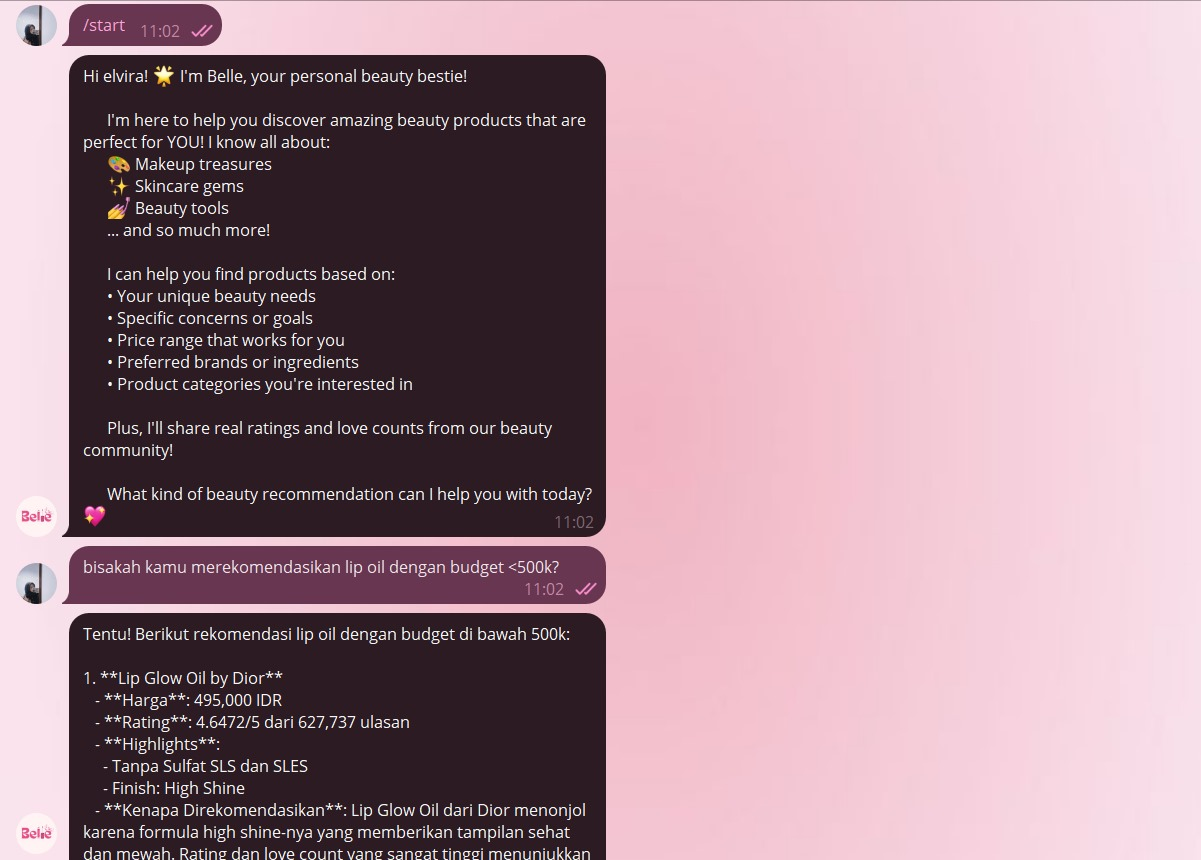